### O desafio

A Frexco trabalha com **produtos perecíveis** e muitos deles possuem uma data de **validade curta**. Acertar na previsão de demanda é essencial para **evitar o desperdício de alimentos**, além de **garantir que a disponibilidade do produto no estoque para venda**.

Tendo isso em mente, estruture um script no Python que calcule a **previsão de demanda para os próximos 5 dias** do item, baseando-se no histórico presente na base de dados em anexo.


### Preparação do ambiente

Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importação dos dados

In [2]:
vendas = pd.read_excel('Dados.xlsx', index_col='Data', parse_dates=True)

In [3]:
vendas.head()

,Vendas
Data,
2022-12-06,870
2022-12-07,868
2022-12-08,1189
2022-12-09,742
2022-12-10,317


In [4]:
vendas.shape

(46, 1)

In [5]:
vendas.describe()

,Vendas
count,46.000000
mean,755.434783
std,430.762201
min,18.000000
25%,346.500000
50%,810.500000
75%,1053.750000
max,1692.000000


In [6]:
vendas.index.min(), vendas.index.max()

(Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-20 00:00:00'))

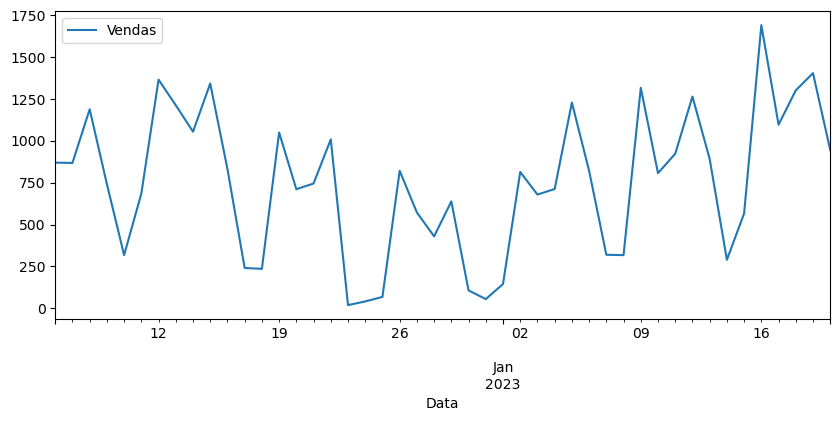

In [8]:
vendas.plot(figsize=(10,4))
plt.show()

### Modelo de Previsão

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

Decomposição da série

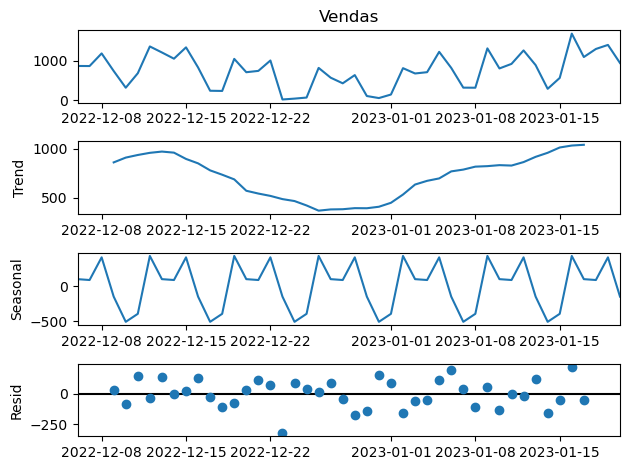

In [13]:
resultado = seasonal_decompose(vendas['Vendas'])
resultado.plot()

Percebe-se, com os dados de venda dos meses de dezembro e janeiro, que a série possui uma tendência de crescimento no início do mês e uma tendência de queda no final do mês.

Teste de estacionariedade

In [17]:
from statsmodels.tsa.stattools import adfuller

In [16]:
result=adfuller(vendas['Vendas'])
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.507607361196456
p-valor:0.5297447855798443


Série não estacionária!

In [23]:
result=adfuller(vendas.diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.174417283436759
p-valor:0.21566116101896976


ARIMA

In [24]:
from pmdarima import auto_arima


In [96]:
#import sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [99]:
fit_arima = auto_arima(vendas['Vendas'], seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=685.345, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=691.562, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=684.840, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=682.402, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=754.957, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=682.867, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=684.357, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=686.390, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=718.872, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.767 seconds


In [97]:
modelo = SARIMAX(vendas['Vendas'], order=(0,0,1), seasonal_order=(0,0,0,0))
resultado_arima = modelo.fit()

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [100]:
resultado_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Vendas   No. Observations:                   46
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -357.436
Date:                Tue, 31 Jan 2023   AIC                            718.872
Time:                        09:40:02   BIC                            722.529
Sample:                    12-06-2022   HQIC                           720.242
                         - 01-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9124      0.063     14.506      0.000       0.789       1.036
sigma2      3.162e+05   8.19e+04      3.860      0.000    1.56e+05    4.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.51   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.01   Prob(JB):                         0.38
Heteroskedasticity (H):               1.50   Skew:                             0.06
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vendas estimadas para os últimos 5 dias

In [106]:
previsao = resultado_arima.get_prediction(start=-5)
previsao_media = previsao.predicted_mean

In [120]:
intervalo_confianca

,lower Vendas,upper Vendas
2023-01-16,-316.784788,1887.387503
2023-01-17,-274.891912,1929.266399
2023-01-18,-855.918230,1348.228444
2023-01-19,-138.791737,2065.345251
2023-01-20,-699.064482,1505.064445


In [107]:
intervalo_confianca = previsao.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(-316.78478841380036, 1887.387503289865)

In [108]:
previsao_media[0]

785.3013574380324

In [109]:
datas_previsao = np.asarray(previsao_media.index)
datas = np.asarray(vendas.index)

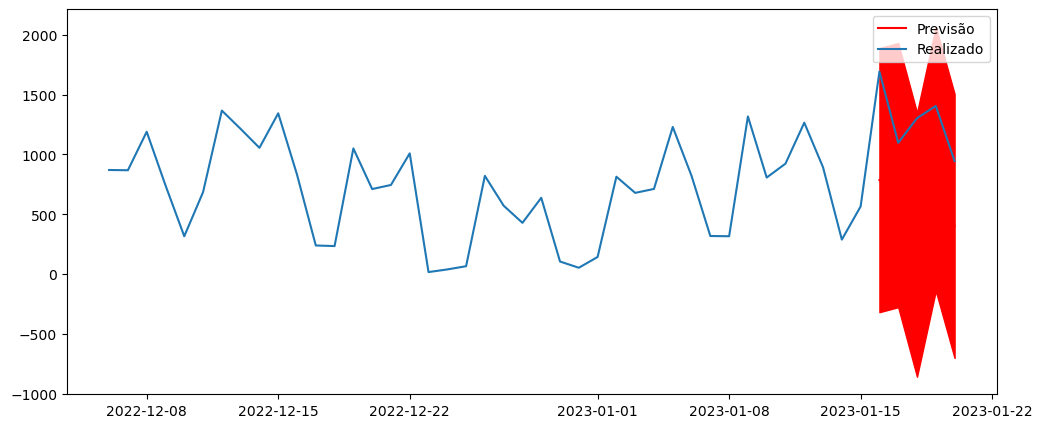

In [110]:
plt.figure(figsize=(12,5))
plt.plot(datas_previsao, previsao_media.values, color='red', label='Previsão')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, vendas.values, label='Realizado')
plt.legend()
plt.show()

Vendas estimadas para os próximos 5 dias

In [111]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(vendas[-5:].values,previsao_media.values))
print(rmse_sarima)

706.9078062550037


In [112]:
# Forecast pra 12 values

forecast = resultado_arima.get_forecast(steps=5)
forecast_medio = forecast.predicted_mean
forecast_medio.size


5

In [113]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[4], intervalo_acima_f[4]

(-1491.8073626253135, 1491.8073626253135)

In [114]:
forecast_medio[4]

0.0

In [115]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

In [118]:
vendas.tail()

,Vendas
Data,
2023-01-16,1692
2023-01-17,1097
2023-01-18,1302
2023-01-19,1405
2023-01-20,945


In [117]:
previsao_media

2023-01-16    785.301357
2023-01-17    827.187244
2023-01-18    246.155107
2023-01-19    963.276757
2023-01-20    402.999982
Freq: D, Name: predicted_mean, dtype: float64

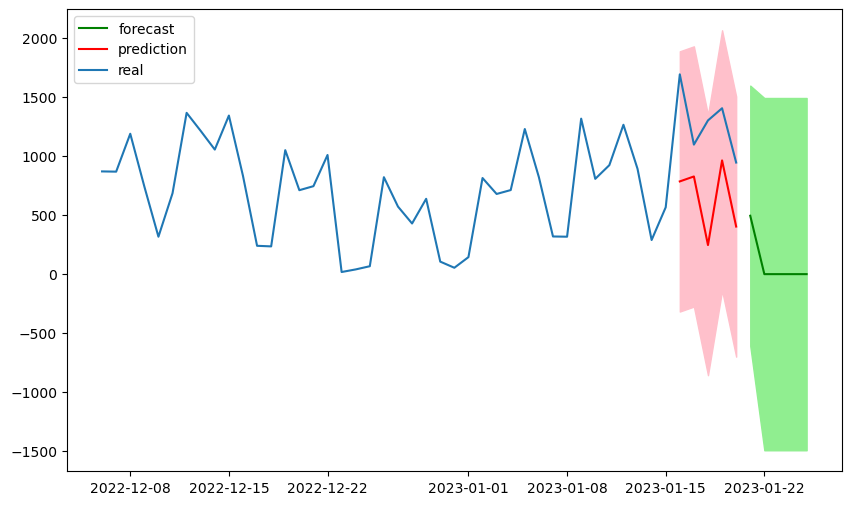

In [116]:
dates=np.asarray(vendas.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,previsao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,vendas.values, label='real')
plt.legend(loc='upper left')
plt.show()

### Previsão com XGBoost

In [61]:
from xgboost import XGBRegressor

In [158]:
vendas.tail()

,Vendas
Data,
2023-01-16,1692
2023-01-17,1097
2023-01-18,1302
2023-01-19,1405
2023-01-20,945


In [171]:
treino = vendas.loc[vendas.index <= '2023-01-14']
validacao = vendas.loc[vendas.index > '2023-01-14']

treino.shape, validacao.shape

((40, 1), (6, 1))

In [172]:
treino.index.min(), treino.index.max()

(Timestamp('2022-12-06 00:00:00'), Timestamp('2023-01-14 00:00:00'))

In [173]:
validacao.index.min(), validacao.index.max()

(Timestamp('2023-01-15 00:00:00'), Timestamp('2023-01-20 00:00:00'))

Variável target

In [174]:
treino['target'] = treino['Vendas'].shift(-1)
treino.head()

<ipython-input-174-82dd01830417>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['Vendas'].shift(-1)


,Vendas,target
Data,,
2022-12-06,870,868.0
2022-12-07,868,1189.0
2022-12-08,1189,742.0
2022-12-09,742,317.0
2022-12-10,317,685.0


In [175]:
treino = treino.dropna()
treino.tail()

,Vendas,target
Data,,
2023-01-09,1317,807.0
2023-01-10,807,923.0
2023-01-11,923,1265.0
2023-01-12,1265,892.0
2023-01-13,892,289.0


In [176]:
validacao['target'] = validacao['Vendas'].shift(-1)
validacao

<ipython-input-176-296c9c8bc14f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['target'] = validacao['Vendas'].shift(-1)


,Vendas,target
Data,,
2023-01-15,566,1692.0
2023-01-16,1692,1097.0
2023-01-17,1097,1302.0
2023-01-18,1302,1405.0
2023-01-19,1405,945.0
2023-01-20,945,NaN


In [177]:
validacao = validacao.dropna()
validacao.tail()

,Vendas,target
Data,,
2023-01-15,566,1692.0
2023-01-16,1692,1097.0
2023-01-17,1097,1302.0
2023-01-18,1302,1405.0
2023-01-19,1405,945.0


In [180]:
X_treino = treino.loc[:, ['Vendas']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['Vendas']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((39, 1), (39, 1), (5, 1), (5, 1))

In [183]:
modelo_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgb.fit(X_treino, y_treino)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [215]:
#criar datetime index do dia 21/01/2023 até 25/01/2023

data_predicao = pd.date_range(start='2023-01-20', end='2023-01-24')
df_predicao = pd.DataFrame(index=data_predicao, data={'Vendas': predicao})

In [218]:
pd.concat([vendas, df_predicao], axis=0)

,Vendas
2022-12-06,870.000000
2022-12-07,868.000000
2022-12-08,1189.000000
2022-12-09,742.000000
2022-12-10,317.000000
2022-12-11,685.000000
2022-12-12,1366.000000
2022-12-13,1213.000000
2022-12-14,1055.000000
2022-12-15,1343.000000


In [222]:
vendas_jan = vendas.loc[vendas.index.month == 1]

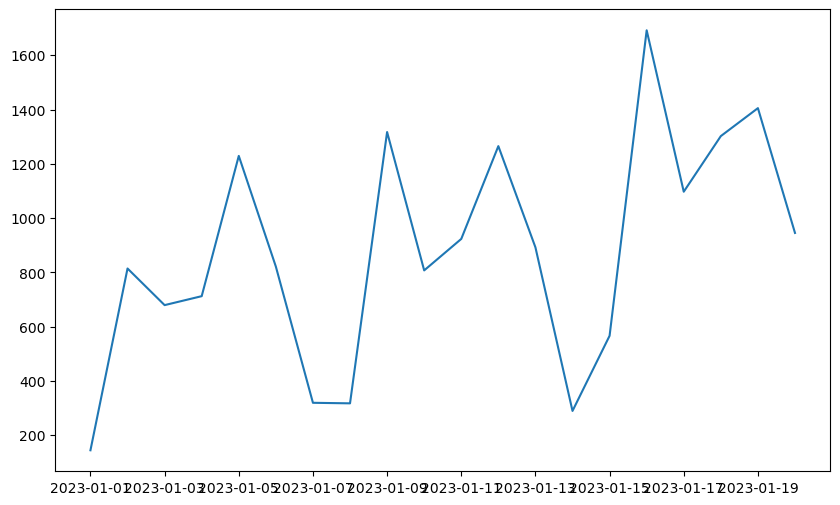

In [223]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(vendas_jan)

plt.show()